# Analysis for once-through scenarios
This notebook provides analysis for all of the once-through fuel cycle scenarios that are included in 
Amanda Bachmann's dissertation. Analysis of each scenario includes the number of reactors deployed, the uranium resources, the SWU capacity, and the amount of waste produced. 

Scenarios are numbers as follows:
* 1: LWRs
* 2: MMR, no growth
* 3: Xe-100, no growth
* 4: Xe-100 and MMR, no growth
* 5: MMR and VOYGR, no growth
* 6: Xe-100 and VOYGR, no growth
* 7: Xe-100, MMR, and VOYGR, no growth
* 8: MMR, 1% growth
* 9: Xe-100, 1% growth
* 10: Xe-100 and MMR, 1% growth
* 11: MMR and VOYGR, 1% growth
* 12: Xe-100 and VOYGR, 1% growth
* 13: Xe-100, MMR, and VOYGR, 1% growth

Analysis of scenario 1 is performed separately, then the no growth scenarios are all analyzed together, followed by the 1% growth scenarios. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys

import cymetric as cym
sys.path.insert(0,'../../../scripts')
import transition_metrics as tm

In [2]:
# Enrichment Constants
assays = {'LWR': 0.043, 'MMR':0.13, 'Xe-100':0.155, 
          'VOYGR':0.0409, 'feed':0.00711,'tails':0.002}

# Reactor Deployment Constants
non_lwr = ['Sink_HLW', 'Sink_LLW', 'Mine',
                 'Enrichment', 'DryStorage', 'United States',
                 'WetStorage', 'FuelCycle', 'UNITED_STATES_OF_AMERICA',
                 'MMR', 'Xe-100','VOYGR', 'Xe-100CoolingPool',
                 'MMRCoolingPool', 'VOYGRCoolingPool']
adv_rxs = ['MMR', 'Xe-100', 'VOYGR']

#Plotting orders
plotting_order_nogrowth = ['s5', 's2', 's7', 's6','s3', 's4']
plotting_order_1percent = ['s11', 's08', 's13', 's12','s09','s10']

# Mass fraction of uranium in fuel for each type of reactor
uranium_fractions = {'LWR':1, 'MMR':0.8857, 'Xe-100':0.895285, 'VOYGR':0.881427}

#Waste commodity names for each type of reactor
waste_commodity = {'LWR':'spent_uox', 'MMR':'spent_MMR_haleu',
                   'Xe-100':'spent_xe100_haleu', 'VOYGR':'spent_smr_fuel'}

#Time period
time = np.linspace(2025, 2089, 65)

## Scenario 1

In [3]:
s1_outfile = "../outputs/united_states_2020.sqlite"

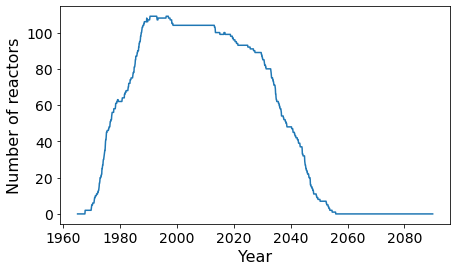

In [4]:
# Reactor Deployment
s1_nonlwr = ['Sink_HLW', 'Sink_LLW', 'Mine',
                 'Enrichment', 'DryStorage', 'United States',
                 'WetStorage', 'FuelCycle', 'UNITED_STATES_OF_AMERICA']
s1_reactors = tm.get_lwr_totals(s1_outfile, s1_nonlwr)
s1_reactors = tm.add_year(s1_reactors)

plt.figure(figsize=(7,4))
plt.plot(s1_reactors['Year'], s1_reactors['lwr_total'])
plt.xlabel('Year', size=16)
plt.ylabel('Number of reactors', size=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('figures/s1_reactors.pdf')

In [5]:
s1_metrics = tm.get_metrics(s1_outfile)
s1_agents = s1_metrics.eval("Agents")
s1_lwrs = s1_agents.loc[s1_agents['Spec'] == ':cycamore:Reactor']

In [16]:
print('Total Number of LWRs deployed:', len(s1_lwrs))
print('Max LWRs deployed:', s1_reactors['lwr_total'].max())
print('LWRS deployed in January 2025:', s1_reactors['lwr_total'][721])
print(s1_reactors[['lwr_total','Year']][1087:1091])
print(s1_reactors[['lwr_total','Year']][30:35])

Total Number of LWRs deployed: 115
Max LWRs deployed: 109.0
LWRS deployed in January 2025: 92.0
Prototype  lwr_total     Year
1087             1.0  2055.58
1088             1.0  2055.67
1089             1.0  2055.75
1090             0.0  2055.83
Prototype  lwr_total     Year
30               0.0  1967.50
31               0.0  1967.58
32               2.0  1967.67
33               2.0  1967.75
34               2.0  1967.83


In [7]:
#energy
s1_energy = tm.get_annual_electricity(s1_outfile)
s1_energy[55:60]

,Year,Energy
55,2022,90.417083
56,2023,90.846333
57,2024,90.042667
58,2025,89.456500
59,2026,88.280583


Annual electricity for 2025:89.45655 GWe-yr


Monthly electricity for 2025:
* January: 91.448
* February: 91.412
* March: 91.376
* April: 89.396
* May: 88.573
* June: 89.3
* July: 91.130
* August: 84.061
* Spetember: 86.184
* October: 91.514
* November:90.791
* December: 83.104

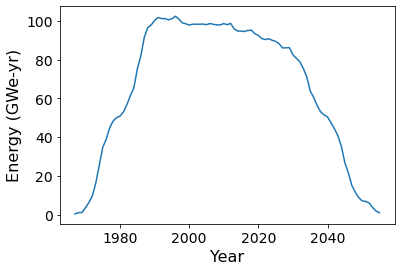

In [8]:
plt.plot(s1_energy['Year'], s1_energy['Energy'])
plt.xlabel('Year', fontsize=16)
plt.ylabel('Energy (GWe-yr)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('figures/s1_energy.pdf')

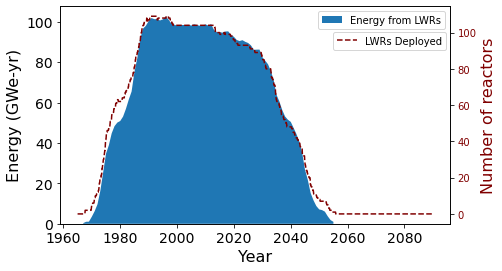

In [9]:
#combine energy and reactors for scenario 1 into a single plot
fig = plt.figure(figsize=(7,4))
ax1 = fig.add_subplot(111)
ax1.stackplot(s1_energy['Year'], s1_energy['Energy'], labels=['Energy from LWRs'])
ax1.legend()
ax1.set_ylabel('Energy (GWe-yr)', fontsize=16)

ax2 = ax1.twinx()
ax2.plot(s1_reactors['Year'], s1_reactors['lwr_total'], 'maroon', 
         linestyle='--', label='LWRs Deployed')
ax2.legend(loc=(0.7, 0.8))
ax2.set_ylabel('Number of reactors', color='maroon', fontsize=16)
ax2.tick_params(axis='y', labelcolor='maroon')

ax1.set_xlabel('Year', fontsize=16)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(axis='both', which='minor', labelsize=14)
ax2.tick_params(axis='both', which='minor', labelsize=14)
plt.savefig('figures/s1_energy_reactors.pdf', bbox_inches='tight')

In [10]:
s1_transactions = tm.add_receiver_prototype(s1_outfile)

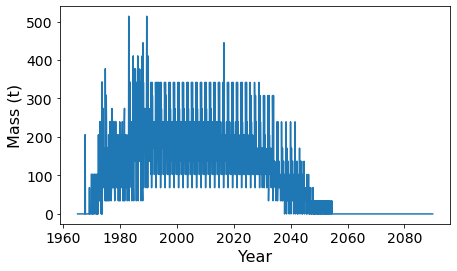

In [17]:
#Uranium resources sent to reactors
s1_uox = tm.commodity_mass_traded(s1_transactions, 'fresh_uox')
plt.figure(figsize=(7,4))
plt.plot(s1_uox['Year'], s1_uox['Quantity']/1000)
plt.ylabel('Mass (t)', fontsize=16)
plt.xlabel('Year', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('figures/s1_uox.pdf', bbox_inches='tight')

In [24]:
print('Max uranium:',s1_uox['Quantity'].max())
print('Average across entire time:',s1_uox['Quantity'][32:1089].mean())
print('Average after 2025:',s1_uox['Quantity'][721:1089].mean())
print('Average before 2025:',s1_uox['Quantity'][32:721].mean())
print('Total after 2025:', s1_uox['Quantity'][721:].cumsum()[1499])

Max uranium: 513717.84232364414
Average across entire time: 135742.53053148882
Average after 2025: 81110.40952552758
Average before 2025: 164921.95074947685
Total after 2025: 29848630.705394212


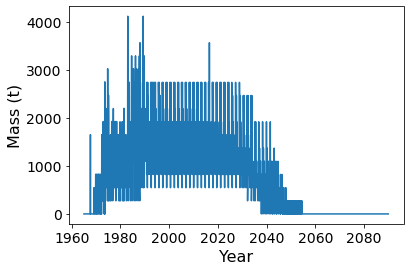

In [20]:
#Natural uranium needed
s1_tails = tm.calculate_tails(s1_uox['Quantity'], assays['LWR'], assays['tails'], assays['feed'])
s1_feed = tm.calculate_feed(s1_uox['Quantity'], s1_tails)

plt.plot(s1_uox['Year'], s1_feed/1000)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Mass (t)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.savefig('figures/s1_feed.pdf', bbox_inches='tight')

In [22]:
print('Maximum needed:',s1_feed.max())
print('Average feed:',s1_feed[32:1089].mean())
print('Average feed after 2025:', s1_feed[721:1089].mean())
print('Average feed before 2025:', s1_feed[32:721].mean())

Maximum needed: 4121806.5626750314
Average feed: 1089127.9357712409
Average feed after 2025: 650788.0216333915
Average feed before 2025: 1323248.5285183073


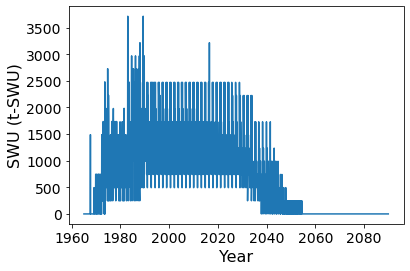

In [25]:
# SWU capacity 
s1_swu = tm.calculate_SWU(s1_uox['Quantity'], assays['LWR'], s1_tails, 
                          assays['tails'], s1_feed, assays['feed'])
plt.plot(s1_uox["Year"], s1_swu/1000)
plt.xlabel('Year', fontsize=16)
plt.ylabel('SWU (t-SWU)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.savefig('figures/s1_swu.pdf', bbox_inches='tight')

In [27]:
print('Maximum needed:',s1_swu.max())
print('Average SWU:',s1_swu[32:1089].mean())
print('Average SWU after 2025:', s1_swu[721:1089].mean())
print('Average SWU before 2025:', s1_swu[32:721].mean())

Maximum needed: 3714166.4210974053
Average SWU: 981414.9077135144
Average SWU after 2025: 586426.1169098741
Average SWU before 2025: 1192381.3446013804


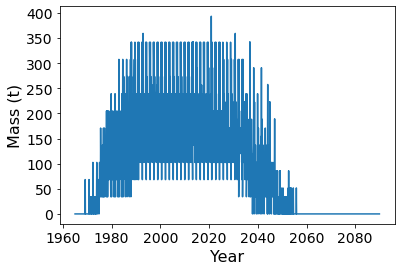

In [28]:
# waste discharged
s1_waste = tm.commodity_mass_traded(s1_transactions, 'spent_uox')

plt.plot(s1_waste['Year'], s1_waste['Quantity']/1000)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Mass (t)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('figures/s1_waste.pdf', bbox_inches='tight')

In [31]:
print('Maximum needed:',s1_waste['Quantity'].max())
print('Average waste:',s1_waste['Quantity'][32:1089].mean())
print('Average waste after 2025:', s1_waste['Quantity'][721:1089].mean())
print('Average waste before 2025:', s1_waste['Quantity'][32:721].mean())

Maximum needed: 393622.40663899935
Average waste: 130113.73298735515
Average waste after 2025: 93898.30642251472
Average waste before 2025: 149456.66038338022


## No growth scenarios

In [32]:
out_files_nogrowth = {'s2_outfile':"../outputs/mmr_nogrowth.sqlite",
            's3_outfile':"../outputs/xe100_nogrowth.sqlite",
            's4_outfile':"../outputs/xe100_mmr_nogrowth.sqlite",
            's5_outfile':"../outputs/mmr_voygr_nogrowth.sqlite",
            's6_outfile':"../outputs/xe100_voygr_nogrowth.sqlite",
            's7_outfile':"../outputs/xe100_mmr_voygr_nogrowth.sqlite"}

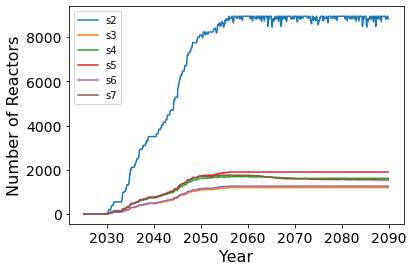

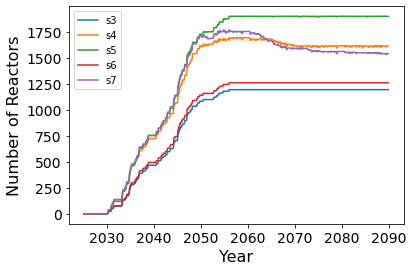

In [41]:
reactors_nogrowth = {'s2_reactors':'',
            's3_reactors':"",
            's4_reactors':"",
            's5_reactors':"",
            's6_reactors':"",
            's7_reactors':""}
plt.figure(0)
for key in reactors_nogrowth:
    scenario = key[:2]
    reactors_nogrowth[key] = tm.get_prototype_totals(out_files_nogrowth[scenario+'_outfile'], non_lwr, adv_rxs)
    plt.plot(reactors_nogrowth[key]['Year'][721:], reactors_nogrowth[key]['advrx_total'][721:], label=scenario)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Number of Reactors', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.savefig('figures/nogrowth_reactors.pdf', bbox_inches='tight')

plt.figure(1)
for key in ['s3_reactors','s4_reactors','s5_reactors','s6_reactors','s7_reactors']:
    scenario = key[:2]
    reactors_nogrowth[key] = tm.get_prototype_totals(out_files_nogrowth[scenario+'_outfile'], non_lwr, adv_rxs)
    plt.plot(reactors_nogrowth[key]['Year'][721:], reactors_nogrowth[key]['advrx_total'][721:], label=scenario)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Number of Reactors', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.savefig('figures/nogrowth_reactors_3-7.pdf', bbox_inches='tight')

In [34]:
for key in reactors_nogrowth:
    scenario = key[1]
    for adv_rx in adv_rxs:
        print(f'Max {adv_rx} in S{scenario}:', reactors_nogrowth[key][adv_rx +'_total'].max())
        print(f'Max {adv_rx} added in one step in S{scenario}:', reactors_nogrowth[key][adv_rx +'_enter'].max())
        prototype_sum = reactors_nogrowth[key][adv_rx +'_enter'].cumsum()
        print(f'Total number of {adv_rx} deployed in S{scenario}:', prototype_sum.iloc[-1])
    print(f'Max Adv Rx in S{scenario}:', reactors_nogrowth[key]['advrx_total'].max())
    print(f'Max Adv Rx added in one step in S{scenario}:', reactors_nogrowth[key]['advrx_enter'].max())
    advrx_sum = reactors_nogrowth[key]['advrx_enter'].cumsum()
    print(f'Total number of reactors deployed in S{scenario}:', advrx_sum.iloc[-1])  

Max MMR in S2: 8946.0
Max MMR added in one step in S2: 378.0
Total number of MMR deployed in S2; 25887.0
Max Xe-100 in S2: 0.0
Max Xe-100 added in one step in S2: 0.0
Total number of Xe-100 deployed in S2; 0.0
Max VOYGR in S2: 0.0
Max VOYGR added in one step in S2: 0.0
Total number of VOYGR deployed in S2; 0.0
Max Adv Rx in S2: 8946.0
Max Adv Rx added in one step in S2: 378.0
Total number of reactors deployed in S2: 25887.0
Max MMR in S3: 0.0
Max MMR added in one step in S3: 0.0
Total number of MMR deployed in S3; 0.0
Max Xe-100 in S3: 1193.0
Max Xe-100 added in one step in S3: 50.0
Total number of Xe-100 deployed in S3; 1193.0
Max VOYGR in S3: 0.0
Max VOYGR added in one step in S3: 0.0
Total number of VOYGR deployed in S3; 0.0
Max Adv Rx in S3: 1193.0
Max Adv Rx added in one step in S3: 50.0
Total number of reactors deployed in S3: 1193.0
Max MMR in S4: 623.0
Max MMR added in one step in S4: 26.0
Total number of MMR deployed in S4; 1587.0
Max Xe-100 in S4: 1128.0
Max Xe-100 added in o

In [ ]:
# Energy
energy_nogrowth = {'s2_energy':'', 's3_energy':'', 's4_energy':'',
          's5_energy':'', 's6_energy':'', 's7_energy':''}
for key in energy_nogrowth:
    scenario = key[:2]
    energy_nogrowth[key] = tm.get_annual_electricity(out_files_nogrowth[scenario + '_outfile'])
    plt.plot(energy_nogrowth[key]['Year'], energy_nogrowth[key]['Energy'], label=scenario)
plt.plot(np.linspace(2025,2089,65), np.repeat(89.45655, 65), 'k', label='Demand')
plt.xlabel('Year', fontsize=16)
plt.ylabel('Energy (GWe-yr)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.savefig('figures/nogrowth_energy.pdf', bbox_inches='tight')

In [ ]:
# Fuel mass
transactions_nogrowth = {'s2':'', 's3':'', 's4':'','s5':'', 's6':'','s7':''}
total_fuel_nogrowth = {'s2':'', 's3':'', 's4':'',
             's5':'', 's6':'', 's7':''}
for key in total_fuel_nogrowth:
    scenario = key[:2]
    transactions_nogrowth[scenario] = tm.add_receiver_prototype(out_files_nogrowth[scenario + '_outfile'])
    fuel = tm.commodity_mass_traded(transactions_nogrowth[scenario], 'fresh_uox')
    total_fuel_nogrowth[key] = tm.add_year(fuel)

In [ ]:
for key in plotting_order_nogrowth: 
    plt.plot(total_fuel_nogrowth[key]['Year'], total_fuel_nogrowth[key]['Quantity']/1000, label=key)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Mass of fuel (t)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.savefig('figures/nogrowth_fuel.pdf', bbox_inches='tight')

In [ ]:
#Dividing fuel mass by prototype
fuel_to_reactors_nogrowth = {'s2_MMR':'', 's2_Xe-100':'', 's2_VOYGR':'', 's2_LWR':'',
                       's3_MMR':'', 's3_Xe-100':'', 's3_VOYGR':'', 's3_LWR':'',
                       's4_MMR':'', 's4_Xe-100':'', 's4_VOYGR':'', 's4_LWR':'',
                       's5_MMR':'', 's5_Xe-100':'', 's5_VOYGR':'', 's5_LWR':'',
                       's6_MMR':'', 's6_Xe-100':'', 's6_VOYGR':'', 's6_LWR':'',
                       's7_MMR':'', 's7_Xe-100':'', 's7_VOYGR':'', 's7_LWR':''}
uranium_to_reactors_nogrowth = {'s2_MMR':'', 's2_Xe-100':'', 's2_VOYGR':'', 's2_LWR':'', 's2_total':'',
                       's3_MMR':'', 's3_Xe-100':'', 's3_VOYGR':'', 's3_LWR':'', 's3_total':'',
                       's4_MMR':'', 's4_Xe-100':'', 's4_VOYGR':'', 's4_LWR':'', 's4_total':'',
                       's5_MMR':'', 's5_Xe-100':'', 's5_VOYGR':'', 's5_LWR':'', 's5_total':'',
                       's6_MMR':'', 's6_Xe-100':'', 's6_VOYGR':'', 's6_LWR':'', 's6_total':'',
                       's7_MMR':'', 's7_Xe-100':'', 's7_VOYGR':'', 's7_LWR':'', 's7_total':'',}
for key in fuel_to_reactors_nogrowth:
    scenario = key[:2]
    reactor = key[3:]
    if reactor == 'LWR':
        fuel_to_reactors_nogrowth[key] = tm.commodity_to_LWR(transactions_nogrowth[scenario], 
                                                        'fresh_uox', adv_rxs)
    elif reactor != 'total': 
        fuel_to_reactors_nogrowth[key] = tm.commodity_to_prototype(transactions_nogrowth[scenario], 
                                                        'fresh_uox', reactor)
    uranium_to_reactors_nogrowth[key] = fuel_to_reactors_nogrowth[key]['Quantity']*uranium_fractions[reactor]

In [ ]:
for key in plotting_order_nogrowth:
    
    plt.figure(0)
    AR_fuel = fuel_to_reactors_nogrowth[key + '_MMR'].copy()
    for reactor in ['Xe-100', 'VOYGR']:
        AR_fuel['Quantity'] += fuel_to_reactors_nogrowth[key+'_'+reactor]['Quantity']
    plt.plot(AR_fuel['Year'], AR_fuel['Quantity']/1000, label=key)
    plt.legend()
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass of fuel (t)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('figures/nogrowth_AR_fuel.pdf', bbox_inches='tight')
  
    plt.figure(1)
    AR_uranium = uranium_to_reactors_nogrowth[key + '_MMR'].copy()
    for reactor in ['Xe-100', 'VOYGR']:
        AR_uranium += uranium_to_reactors_nogrowth[key+'_'+reactor]
    plt.plot(AR_fuel['Year'], AR_uranium/1000, label=key)
    plt.legend()
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass of uranium (t)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('figures/nogrowth_AR_uranium.pdf', bbox_inches='tight')
    
    plt.figure(2)
    uranium_to_reactors_nogrowth[key + '_total'] = AR_uranium + \
            uranium_to_reactors_nogrowth[key+'_LWR']
    plt.plot(AR_fuel['Year'], uranium_to_reactors_nogrowth[key+'_total']/1000, label=key)
    plt.legend()
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass of uranium (t)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('figures/nogrowth_uranium.pdf', bbox_inches='tight')
    
    plt.figure(3)
    plt.plot(fuel_to_reactors_nogrowth[key+'_MMR']['Year'], 
             uranium_to_reactors_nogrowth[key+'_total'].cumsum()/1000, label=key)
    plt.legend()
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass of uranium (t)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('figures/nogrowth_uranium_cumulative.pdf', bbox_inches='tight')
    

In [ ]:
#Reporting uranium masses
for scenario in plotting_order_nogrowth:
    print('Average mass in', scenario, ':', uranium_to_reactors_nogrowth[scenario+'_total'].mean())
    print('Maximum mass in', scenario, ':', uranium_to_reactors_nogrowth[scenario+'_total'].max())
    for reactor in adv_rxs:
        print('Average sent to', scenario, reactor, 'after 2025:', 
                  uranium_to_reactors_nogrowth[scenario+'_'+reactor][721:].mean())
        print('Maximum sent to', scenario, reactor, 'after 2025:', 
                  uranium_to_reactors_nogrowth[scenario+'_'+reactor][721:].max())
    HALEU_mass = uranium_to_reactors_nogrowth[scenario+'_MMR'] + uranium_to_reactors_nogrowth[scenario+'_Xe-100']
    print('Average HALEU mass in', scenario,'after 2025:', HALEU_mass[721:].mean())
    print('Maximum HALEU mass in', scenario,'after 2025:', HALEU_mass[721:].max())

In [ ]:
#SWU Calculations
tails_nogrowth = {'s2_MMR':'', 's2_Xe-100':'', 's2_VOYGR':'', 's2_LWR':'',
        's3_MMR':'', 's3_Xe-100':'', 's3_VOYGR':'', 's3_LWR':'',
        's4_MMR':'', 's4_Xe-100':'', 's4_VOYGR':'', 's4_LWR':'',
        's5_MMR':'', 's5_Xe-100':'', 's5_VOYGR':'', 's5_LWR':'',
        's6_MMR':'', 's6_Xe-100':'', 's6_VOYGR':'', 's6_LWR':'',
        's7_MMR':'', 's7_Xe-100':'', 's7_VOYGR':'', 's7_LWR':''}
feed_nogrowth = {'s2_MMR':'', 's2_Xe-100':'', 's2_VOYGR':'', 's2_LWR':'', 's2_total':'',
        's3_MMR':'', 's3_Xe-100':'', 's3_VOYGR':'', 's3_LWR':'', 's3_total':'',
        's4_MMR':'', 's4_Xe-100':'', 's4_VOYGR':'', 's4_LWR':'', 's4_total':'',
        's5_MMR':'', 's5_Xe-100':'', 's5_VOYGR':'', 's5_LWR':'', 's5_total':'',
        's6_MMR':'', 's6_Xe-100':'', 's6_VOYGR':'', 's6_LWR':'', 's6_total':'',
        's7_MMR':'', 's7_Xe-100':'', 's7_VOYGR':'', 's7_LWR':'', 's7_total':'',}
SWU_nogrowth = {'s2_MMR':'', 's2_Xe-100':'', 's2_VOYGR':'', 's2_LWR':'', 's2_total':'',
        's3_MMR':'', 's3_Xe-100':'', 's3_VOYGR':'', 's3_LWR':'', 's3_total':'',
        's4_MMR':'', 's4_Xe-100':'', 's4_VOYGR':'', 's4_LWR':'', 's4_total':'',
        's5_MMR':'', 's5_Xe-100':'', 's5_VOYGR':'', 's5_LWR':'', 's5_total':'',
        's6_MMR':'', 's6_Xe-100':'', 's6_VOYGR':'', 's6_LWR':'', 's6_total':'',
        's7_MMR':'', 's7_Xe-100':'', 's7_VOYGR':'', 's7_LWR':'', 's7_total':'',}
for key in feed_nogrowth:
    reactor = key[3:]
    if reactor != 'total':
        tails_nogrowth[key] = tm.calculate_tails(fuel_to_reactors_nogrowth[key]['Quantity']*uranium_fractions[reactor], 
                                    assays[reactor], assays['tails'], assays['feed'])
        feed_nogrowth[key] = tm.calculate_feed(fuel_to_reactors_nogrowth[key]['Quantity']*uranium_fractions[reactor], 
                                           tails_nogrowth[key])
        SWU_nogrowth[key] = tm.calculate_SWU(fuel_to_reactors_nogrowth[key]['Quantity']*uranium_fractions[reactor],
                                assays[reactor], tails_nogrowth[key], assays['tails'],
                                feed_nogrowth[key], assays['feed'])

In [ ]:
for key in plotting_order_nogrowth:
    AR_feed = feed_nogrowth[key+'_MMR'].copy()
    for reactor in ['Xe-100','VOYGR']:
        AR_feed += feed_nogrowth[key + '_' + reactor]
    plt.figure(0)
    plt.plot(fuel_to_reactors_nogrowth[key + '_MMR']['Year'], AR_feed/1000, label=key)
    plt.legend()
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Feed uranium (t)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('figures/nogrowth_AR_feed.pdf', bbox_inches='tight')
    
    plt.figure(1)
    feed_nogrowth[key+'_total'] = AR_feed + feed_nogrowth[key +'_LWR']
    plt.plot(fuel_to_reactors_nogrowth[key + '_MMR']['Year'], feed_nogrowth[key+'_total']/1000, label=key)
    plt.legend()
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Feed uranium (t)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('figures/nogrowth_feed.pdf', bbox_inches='tight')
    
    plt.figure(2)
    plt.plot(fuel_to_reactors_nogrowth[key+'_MMR']['Year'], feed_nogrowth[key+'_total'].cumsum()/1000, label=key)
    plt.legend()
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass of uranium (t)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('figures/nogrowth_feed_cumulative.pdf', bbox_inches='tight')

In [ ]:
#Reporting feed masses
for scenario in plotting_order_nogrowth:
    print('Average mass in', scenario, ':', feed_nogrowth[scenario+'_total'].mean())
    print('Maximum mass in', scenario, ':', feed_nogrowth[scenario+'_total'].max())
    for reactor in adv_rxs:
        print('Average sent to', scenario, reactor, 'after 2025:', 
                  feed_nogrowth[scenario+'_'+reactor][721:].mean())
        print('Maximum sent to', scenario, reactor, 'after 2025:', 
                  feed_nogrowth[scenario+'_'+reactor][721:].max())

In [ ]:
for key in ['s2', 's5', 's7', 's6','s3', 's4']:
    AR_SWU = SWU_nogrowth[key+'_MMR'].copy()
    for reactor in ['Xe-100','VOYGR']:
        AR_SWU += SWU_nogrowth[key + '_' + reactor]
    plt.figure(0)
    plt.plot(fuel_to_reactors_nogrowth[key + '_MMR']['Year'], AR_SWU/1000, label=key)
    plt.legend()
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('SWU (t-SWU)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('figures/nogrowth_AR_SWU.pdf', bbox_inches='tight')
    
    plt.figure(1)
    SWU_nogrowth[key+'_total'] = AR_SWU + SWU_nogrowth[key +'_LWR']
    plt.plot(fuel_to_reactors_nogrowth[key + '_MMR']['Year'], SWU_nogrowth[key+'_total']/1000, label=key)
    plt.legend()
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('SWU (t-SWU)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('figures/nogrowth_SWU.pdf', bbox_inches='tight')

In [ ]:
#Reporting SWU Requirements
for scenario in plotting_order_nogrowth:
    print('Average mass in ', scenario, ': ', SWU_nogrowth[scenario+'_total'].mean())
    print('Maximum mass in ', scenario, ': ', SWU_nogrowth[scenario+'_total'].max())
    for reactor in adv_rxs:
        print('Average sent to', scenario, reactor, ' after 2025: ', 
                  SWU_nogrowth[scenario+'_'+reactor][721:].mean())
        print('Maximum sent to', scenario, reactor, ' after 2025: ', 
                  SWU_nogrowth[scenario+'_'+reactor][721:].max())

In [ ]:
# Waste discharged from reactors
waste_nogrowth = {'s2_MMR':'', 's2_Xe-100':'', 's2_VOYGR':'', 's2_LWR':'', 's2_total':'',
                    's3_MMR':'', 's3_Xe-100':'', 's3_VOYGR':'', 's3_LWR':'', 's3_total':'',
                    's4_MMR':'', 's4_Xe-100':'', 's4_VOYGR':'', 's4_LWR':'', 's4_total':'',
                    's5_MMR':'', 's5_Xe-100':'', 's5_VOYGR':'', 's5_LWR':'', 's5_total':'',
                    's6_MMR':'', 's6_Xe-100':'', 's6_VOYGR':'', 's6_LWR':'', 's6_total':'',
                    's7_MMR':'', 's7_Xe-100':'', 's7_VOYGR':'', 's7_LWR':'', 's7_total':''}
for key in waste_nogrowth:
    scenario = key[:2]
    reactor = key[3:]
    if reactor != 'total':
        waste_nogrowth[key] = tm.commodity_mass_traded(transactions_nogrowth[scenario], waste_commodity[reactor])

In [ ]:
for key in plotting_order_nogrowth:
    AR_waste = waste_nogrowth[key + '_MMR'].copy()
    for reactor in ['Xe-100', 'VOYGR']:
        AR_waste['Quantity'] += waste_nogrowth[key + '_' + reactor]['Quantity']
    plt.figure(0)
    plt.plot(AR_waste['Year'], AR_waste['Quantity']/1000, label = key)
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass (t)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend()
    plt.savefig('figures/nogrowth_AR_waste.pdf', bbox_inches='tight')
    
    plt.figure(1)
    waste_nogrowth[key+'_total'] = AR_waste['Quantity'] + waste_nogrowth[key + '_LWR']['Quantity']
    plt.plot(AR_waste['Year'], waste_nogrowth[key+'_total']/1000, label=key)
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass (t)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend()
    plt.savefig('figures/nogrowth_waste.pdf', bbox_inches='tight')

In [ ]:
#Reporting waste masses
for scenario in plotting_order_nogrowth:
    print('Average mass in ', scenario, ': ', waste_nogrowth[scenario+'_total'].mean())
    print('Maximum mass in ', scenario, ': ', waste_nogrowth[scenario+'_total'].max())
    for reactor in adv_rxs:
        print('Average sent to', scenario, reactor, ' after 2025: ', 
                  waste_nogrowth[scenario+'_'+reactor]['Quantity'][721:].mean())
        print('Maximum sent to', scenario, reactor, ' after 2025: ', 
                  waste_nogrowth[scenario+'_'+reactor]['Quantity'][721:].max())

## 1% Growth Scenarios

In [60]:
out_files_1percent = {'s08_outfile':"../outputs/mmr_1percent.sqlite",
                    's09_outfile':"../outputs/xe100_1percent.sqlite",
            's10_outfile':"../outputs/xe100_mmr_1percent.sqlite",
            's11_outfile':"../outputs/mmr_voygr_1percent.sqlite",
            's12_outfile':"../outputs/xe100_voygr_1percent.sqlite",
            's13_outfile':"../outputs/xe100_mmr_voygr_1percent.sqlite"}

reactors_1percent = {'s08_reactors':"",'s09_reactors':"",
                    's10_reactors':"",'s11_reactors':"",
                    's12_reactors':"",'s13_reactors':""}

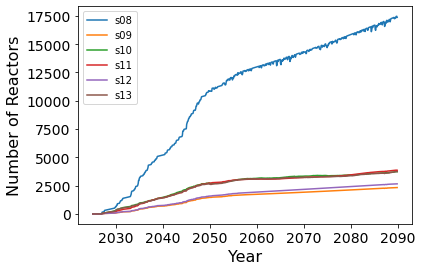

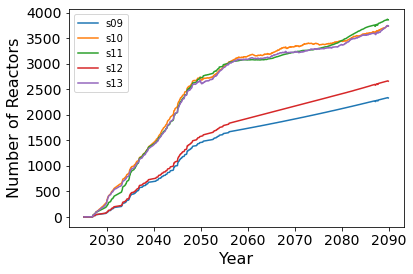

In [64]:
plt.figure(0)
for key in reactors_1percent:
    scenario = key[:3]
    reactors_1percent[key] = tm.get_prototype_totals(out_files_1percent[scenario+'_outfile'], non_lwr, adv_rxs)
    plt.plot(reactors_1percent[key]['Year'][721:], reactors_1percent[key]['advrx_total'][721:], label=scenario)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Number of Reactors', fontsize=16)
plt.legend()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('figures/1percent_reactors.pdf', bbox_inches='tight')

plt.figure(1)
for key in ['s09_reactors','s10_reactors','s11_reactors','s12_reactors','s13_reactors']:
    scenario = key[:3]
    reactors_1percent[key] = tm.get_prototype_totals(out_files_1percent[scenario+'_outfile'], non_lwr, adv_rxs)
    plt.plot(reactors_1percent[key]['Year'][721:], reactors_1percent[key]['advrx_total'][721:], label=scenario)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Number of Reactors', fontsize=16)
plt.legend()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('figures/1percent_reactors_9-13.pdf', bbox_inches='tight')

In [ ]:
for key in reactors_1percent:
    scenario = key[1:3]
    for adv_rx in adv_rxs:
        print(f'Max {adv_rx} in S{scenario}:', reactors_1percent[key][adv_rx +'_total'].max())
        print(f'Max {adv_rx} added in one step in S{scenario}:', reactors_1percent[key][adv_rx +'_enter'].max())
        prototype_sum = reactors_1percent[key][adv_rx +'_enter'].cumsum()
        print(f'Total number of {adv_rx} deployed in S{scenario};', prototype_sum.iloc[-1])
    print(f'Max Adv Rx in S{scenario}:', reactors_1percent[key]['advrx_total'].max())
    print(f'Max Adv Rx added in one step in S{scenario}:', reactors_1percent[key]['advrx_enter'].max())
    advrx_sum = reactors_1percent[key]['advrx_enter'].cumsum()
    print(f'Total number of reactors deployed in S{scenario}:', advrx_sum.iloc[-1])  

In [ ]:
# Energy
energy_1percent = {'s08_energy':'', 's09_energy':'', 's10_energy':'',
                  's11_energy':'', 's12_energy':'', 's13_energy':''}
for key in energy_1percent:
    scenario = key[:3]
    energy_1percent[key] = tm.get_annual_electricity(out_files_1percent[scenario + '_outfile'])
    plt.plot(energy_1percent[key]['Year'], energy_1percent[key]['Energy'], label=scenario)
plt.plot(np.linspace(2025,2089,65), 89.45655* np.exp(0.01*(time-2025)), 'k', label='Demand')
plt.xlabel('Year', fontsize=16)
plt.ylabel('Energy (GWe-yr)', fontsize=16)
plt.legend()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('figures/1percent_energy.pdf', bbox_inches='tight')

In [ ]:
# Fuel mass
transactions_1percent = {'s08':'', 's09':'', 's10':'','s11':'', 's12':'','s13':''}
total_fuel_1percent = {'s08':'', 's09':'', 's10':'',
                       's11':'', 's12':'', 's13':''}

for key in total_fuel_1percent:
    scenario = key[:3]
    transactions_1percent[scenario] = tm.add_receiver_prototype(out_files_1percent[scenario + '_outfile'])
    fuel = tm.commodity_mass_traded(transactions_1percent[scenario], 'fresh_uox')
    total_fuel_1percent[key] = tm.add_year(fuel)

In [ ]:
for key in plotting_order_1percent: 
    plt.plot(total_fuel_1percent[key]['Year'], total_fuel_1percent[key]['Quantity']/1000, label=key)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Mass of fuel (t)', fontsize=16)
plt.legend()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('figures/1percent_fuel.pdf', bbox_inches='tight')

In [ ]:
#Dividing fuel mass by prototype
fuel_to_reactors_1percent = {'s08_MMR':'', 's08_Xe-100':'', 's08_VOYGR':'', 's08_LWR':'',
                       's09_MMR':'', 's09_Xe-100':'', 's09_VOYGR':'', 's09_LWR':'',
                       's10_MMR':'', 's10_Xe-100':'', 's10_VOYGR':'', 's10_LWR':'',
                       's11_MMR':'', 's11_Xe-100':'', 's11_VOYGR':'', 's11_LWR':'',
                       's12_MMR':'', 's12_Xe-100':'', 's12_VOYGR':'', 's12_LWR':'',
                       's13_MMR':'', 's13_Xe-100':'', 's13_VOYGR':'', 's13_LWR':''}
uranium_to_reactors_1percent = {'s08_MMR':'', 's08_Xe-100':'', 's08_VOYGR':'', 's08_LWR':'', 's08_total':'',
                       's09_MMR':'', 's09_Xe-100':'', 's09_VOYGR':'', 's09_LWR':'', 's09_total':'',
                       's10_MMR':'', 's10_Xe-100':'', 's10_VOYGR':'', 's10_LWR':'', 's10_total':'',
                       's11_MMR':'', 's11_Xe-100':'', 's11_VOYGR':'', 's11_LWR':'', 's11_total':'',
                       's12_MMR':'', 's12_Xe-100':'', 's12_VOYGR':'', 's12_LWR':'', 's12_total':'',
                       's13_MMR':'', 's13_Xe-100':'', 's13_VOYGR':'', 's13_LWR':'', 's13_total':'',}

for key in fuel_to_reactors_1percent:
    scenario = key[:3]
    reactor = key[4:]
    if reactor == 'LWR':
        fuel_to_reactors_1percent[key] = tm.commodity_to_LWR(transactions_1percent[scenario], 
                                                        'fresh_uox', adv_rxs)
    elif reactor != 'total': 
        fuel_to_reactors_1percent[key] = tm.commodity_to_prototype(transactions_1percent[scenario], 
                                                        'fresh_uox', reactor)
    uranium_to_reactors_1percent[key] = fuel_to_reactors_1percent[key]*uranium_fractions[reactor]

In [ ]:
for key in plotting_order_1percent:

    plt.figure(0)
    AR_fuel = fuel_to_reactors_1percent[key + '_MMR'].copy()
    for reactor in ['Xe-100', 'VOYGR']:
        AR_fuel['Quantity'] += fuel_to_reactors_1percent[key+'_'+reactor]['Quantity']
    plt.plot(AR_fuel['Year'], AR_fuel['Quantity']/1000, label=key)
    plt.legend()
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass of fuel (t)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('figures/1percent_AR_fuel.pdf', bbox_inches='tight')

    plt.figure(1)
    AR_uranium = uranium_to_reactors_1percent[key + '_MMR'].copy()
    for reactor in ['Xe-100', 'VOYGR']:
        AR_uranium['Quantity'] += uranium_to_reactors_1percent[key+'_'+reactor]['Quantity']
    plt.plot(AR_uranium['Year'], AR_uranium['Quantity']/1000, label=key)
    plt.legend()
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass of uranium (t)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('figures/1percent_AR_uranium.pdf', bbox_inches='tight')

    plt.figure(2)
    uranium_to_reactors_1percent[key+'_total'] = AR_uranium['Quantity'] + \
                                                uranium_to_reactors_1percent[key+'_LWR']['Quantity']
    plt.plot(AR_uranium['Year'], uranium_to_reactors_1percent[key+'_total'], label=key)
    plt.legend()
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass of uranium (t)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('figures/1percent_uranium.pdf', bbox_inches='tight')
    
    plt.figure(3)
    plt.plot(AR_uranium['Year'], uranium_to_reactors_1percent[key+'_total'].cumsum()/1000, label=key)
    plt.legend()
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass of uranium (t)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('figures/1percent_uranium_cumulative.pdf', bbox_inches='tight')

In [ ]:
#Reporting uranium masses
for scenario in plotting_order_1percent:
    print('Average mass in ', scenario, ': ', uranium_to_reactors_1percent[scenario+'_total'].mean())
    print('Maximum mass in ', scenario, ': ', uranium_to_reactors_1percent[scenario+'_total'].max())
    for reactor in adv_rxs:
        print('Average sent to', scenario, reactor, ' after 2025: ', 
                  uranium_to_reactors_1percent[scenario+'_'+reactor]['Quantity'][721:].mean())
        print('Maximum sent to', scenario, reactor, ' after 2025: ', 
                  uranium_to_reactors_1percent[scenario+'_'+reactor]['Quantity'][721:].max())
    HALEU_mass = uranium_to_reactors_1percent[scenario+'_MMR']['Quantity'] + \
                uranium_to_reactors_1percent[scenario+'_Xe-100']['Quantity']
    print('Average HALEU mass in', scenario,'after 2025:', HALEU_mass[721:].mean())
    print('Maximum HALEU mass in', scenario,'after 2025:', HALEU_mass[721:].max())

In [ ]:
#SWU Calculations

tails_1percent = {'s08_MMR':'', 's08_Xe-100':'', 's08_VOYGR':'', 's08_LWR':'',
                       's09_MMR':'', 's09_Xe-100':'', 's09_VOYGR':'', 's09_LWR':'',
                       's10_MMR':'', 's10_Xe-100':'', 's10_VOYGR':'', 's10_LWR':'',
                       's11_MMR':'', 's11_Xe-100':'', 's11_VOYGR':'', 's11_LWR':'',
                       's12_MMR':'', 's12_Xe-100':'', 's12_VOYGR':'', 's12_LWR':'',
                       's13_MMR':'', 's13_Xe-100':'', 's13_VOYGR':'', 's13_LWR':''}

feed_1percent = {'s08_MMR':'', 's08_Xe-100':'', 's08_VOYGR':'', 's08_LWR':'', 's08_total':'',
                       's09_MMR':'', 's09_Xe-100':'', 's09_VOYGR':'', 's09_LWR':'', 's09_total':'',
                       's10_MMR':'', 's10_Xe-100':'', 's10_VOYGR':'', 's10_LWR':'', 's10_total':'',
                       's11_MMR':'', 's11_Xe-100':'', 's11_VOYGR':'', 's11_LWR':'', 's11_total':'',
                       's12_MMR':'', 's12_Xe-100':'', 's12_VOYGR':'', 's12_LWR':'', 's12_total':'',
                       's13_MMR':'', 's13_Xe-100':'', 's13_VOYGR':'', 's13_LWR':'', 's13_total':'',}

SWU_1percent = {'s08_MMR':'', 's08_Xe-100':'', 's08_VOYGR':'', 's08_LWR':'', 's08_total':'',
                       's09_MMR':'', 's09_Xe-100':'', 's09_VOYGR':'', 's09_LWR':'', 's09_total':'',
                       's10_MMR':'', 's10_Xe-100':'', 's10_VOYGR':'', 's10_LWR':'', 's10_total':'',
                       's11_MMR':'', 's11_Xe-100':'', 's11_VOYGR':'', 's11_LWR':'', 's11_total':'',
                       's12_MMR':'', 's12_Xe-100':'', 's12_VOYGR':'', 's12_LWR':'', 's12_total':'',
                       's13_MMR':'', 's13_Xe-100':'', 's13_VOYGR':'', 's13_LWR':'', 's13_total':'',}
for key in feed_1percent:
    scenario = key[:3]
    reactor = key[4:]
    if reactor != 'total':
        tails_1percent[key] = tm.calculate_tails(fuel_to_reactors_1percent[key]['Quantity']*uranium_fractions[reactor], 
                                    assays[reactor], assays['tails'], assays['feed'])
        feed_1percent[key] = tm.calculate_feed(fuel_to_reactors_1percent[key]['Quantity']*uranium_fractions[reactor], 
                                           tails_1percent[key])
        SWU_1percent[key] = tm.calculate_SWU(fuel_to_reactors_1percent[key]['Quantity']*uranium_fractions[reactor],
                                assays[reactor], tails_1percent[key], assays['tails'],
                                feed_1percent[key], assays['feed'])

In [ ]:
for key in plotting_order_1percent:
    AR_feed = feed_1percent[key+'_MMR'].copy()
    for reactor in ['Xe-100','VOYGR']:
        AR_feed += feed_1percent[key + '_' + reactor]
    plt.figure(0)
    plt.plot(fuel_to_reactors_1percent[key + '_MMR']['Year'], AR_feed/1000, label=key)
    plt.legend()
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Feed uranium (t)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('figures/1percent_AR_feed.pdf', bbox_inches='tight')
    
    plt.figure(1)
    feed_1percent[key+'_total'] = AR_feed + feed_1percent[key +'_LWR']
    plt.plot(fuel_to_reactors_1percent[key + '_MMR']['Year'], feed_1percent[key+'_total']/1000, label=key)
    plt.legend()
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Feed uranium (t)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('figures/1percent_feed.pdf', bbox_inches='tight')
    
    plt.figure(2)
    plt.plot(fuel_to_reactors_1percent[key+'_MMR']['Year'], feed_1percent[key+'_total'].cumsum()/1000, label=key)
    plt.legend()
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass of uranium (t)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('figures/1percent_feed_cumulative.pdf', bbox_inches='tight')

In [ ]:
#Reporting feed masses
for scenario in plotting_order_1percent:
    print('Average mass in ', scenario, ': ', feed_1percent[scenario+'_total'].mean())
    print('Maximum mass in ', scenario, ': ', feed_1percent[scenario+'_total'].max())
    for reactor in adv_rxs:
        print('Average sent to', scenario, reactor, ' after 2025: ', 
                  feed_1percent[scenario+'_'+reactor][721:].mean())
        print('Maximum sent to', scenario, reactor, ' after 2025: ', 
                  feed_1percent[scenario+'_'+reactor][721:].max())

In [ ]:
for key in plotting_order_1percent:
    AR_SWU = SWU_1percent[key+'_MMR'].copy()
    for reactor in ['Xe-100','VOYGR']:
        AR_SWU += SWU_1percent[key + '_' + reactor]
    plt.figure(0)
    plt.plot(fuel_to_reactors_1percent[key + '_MMR']['Year'], AR_SWU/1000, label=key)
    plt.legend()
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('SWU (t-SWU)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('figures/1percent_AR_SWU.pdf', bbox_inches='tight')
    
    plt.figure(1)
    SWU_1percent[key+'_total'] = AR_SWU + SWU_1percent[key +'_LWR']
    plt.plot(fuel_to_reactors_1percent[key + '_MMR']['Year'], SWU_1percent[key+'_total']/1000, label=key)
    plt.legend()
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('SWU (t-SWU)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('figures/1percent_SWU.pdf', bbox_inches='tight')

In [ ]:
#Reporting SWU requirements
for scenario in plotting_order_1percent:
    print('Average mass in ', scenario, ': ', SWU_1percent[scenario+'_total'].mean())
    print('Maximum mass in ', scenario, ': ', SWU_1percent[scenario+'_total'].max())
    for reactor in adv_rxs:
        print('Average sent to', scenario, reactor, ' after 2025: ', 
                  SWU_1percent[scenario+'_'+reactor][721:].mean())
        print('Maximum sent to', scenario, reactor, ' after 2025: ', 
                  SWU_1percent[scenario+'_'+reactor][721:].max())

In [ ]:
# Waste discharged from reactors

waste_1percent = {'s08_MMR':'', 's08_Xe-100':'', 's08_VOYGR':'', 's08_LWR':'', 's08_total':'',
                       's09_MMR':'', 's09_Xe-100':'', 's09_VOYGR':'', 's09_LWR':'', 's09_total':'',
                       's10_MMR':'', 's10_Xe-100':'', 's10_VOYGR':'', 's10_LWR':'', 's10_total':'',
                       's11_MMR':'', 's11_Xe-100':'', 's11_VOYGR':'', 's11_LWR':'', 's11_total':'',
                       's12_MMR':'', 's12_Xe-100':'', 's12_VOYGR':'', 's12_LWR':'', 's12_total':'',
                       's13_MMR':'', 's13_Xe-100':'', 's13_VOYGR':'', 's13_LWR':'', 's13_total':'',}

for key in waste_1percent:
    scenario = key[:3]
    reactor = key[4:]
    if reactor != 'total':
        waste_1percent[key] = tm.commodity_mass_traded(transactions_1percent[scenario], waste_commodity[reactor])

In [ ]:
for key in plotting_order_1percent:
    AR_waste = waste_1percent[key + '_MMR'].copy()
    for reactor in ['Xe-100', 'VOYGR']:
        AR_waste['Quantity'] += waste_1percent[key + '_' + reactor]['Quantity']
    plt.figure(0)
    plt.plot(AR_waste['Year'], AR_waste['Quantity']/1000, label = key)
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass (t)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend()
    plt.savefig('figures/1percent_AR_waste.pdf', bbox_inches='tight')

    plt.figure(1)
    waste_1percent[key+'_total'] = AR_waste['Quantity'] + waste_1percent[key + '_LWR']['Quantity']
    plt.plot(AR_waste['Year'], waste_1percent[key+'_total']/1000, label=key)
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass (t)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend()
    plt.savefig('figures/1percent_waste.pdf', bbox_inches='tight')

In [ ]:
#Reporting waste masses
for scenario in plotting_order_1percent:
    print('Average mass in ', scenario, ': ', waste_1percent[scenario+'_total'].mean())
    print('Maximum mass in ', scenario, ': ', waste_1percent[scenario+'_total'].max())
    for reactor in adv_rxs:
        print('Average sent to', scenario, reactor, ' after 2025: ', 
                  waste_1percent[scenario+'_'+reactor]['Quantity'][721:].mean())
        print('Maximum sent to', scenario, reactor, ' after 2025: ', 
                  waste_1percent[scenario+'_'+reactor]['Quantity'][721:].max())